# Chapter 6 요약

```
언젠가 한 번쯤 문서를 요약해야 할 때가 있음

요약할 문서는 연구 논문이나 재무 실적 보고서 아니면 이메일 스레드일지도 모름

생각해보면 이런 작업에는 긴 단락을 이해하고, 관련 내용을 추론하고, 원래 문서의 주제를 통합해 유창한 텍스트를 생성하는 등 다양한 능력이 필요함

또 기사를 정확하게 요약하는 방법과 법률 계약서를 요약하는 방법은 매우 다르기 때문에 정교한 수준의 도메인 일반화가 필요함

이런 이유로 트랜스포머를 포함한 자연어 모델에게 텍스트 요약은 어려운 작업임

이런 어려움에도 불구하고 텍스트 요약은 도메인 전문가의 작업 속도를 크게 높이고 기업에서 내부 지식을 집약하고, 계약을 요약하고 소셜 미디어를 위한 자동 콘텐츠를 생성하는 등의 작업에 사용됨

요약은 입력과 출력이 텍스트인 고전적인 시퀀스-투-시퀀스(Seq2Seq) 작업임

요약에는 인코더-디코더 트랜스포머가 잘 맞음
```

## 6.1 CNN/DailyMail 데이터셋

```
CNN/DailyMail 데이터셋은 300,000개 뉴스 기사와 요약의 쌍으로 구성되어 있음

요약은 CNN 과 DailyMail 이 기사에 첨부한 글머리 목록의 내용인데, 요약이 본문에서 추출되지 않고 추상적이라는 중요한 특징이 있음

즉, 단순한 발췌가 아니라 새로운 문장으로 구성됐다는 말임

여기서는 요약을 위해 익명화 처리를 하지 않은 3.0.0 버전을 사용하겠음
```

In [1]:
from datasets import load_dataset

In [5]:
# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
# dataset = load_dataset('cnn_dailymail', version='3.0.0')
dataset = load_dataset('ccdv/cnn_dailymail', version='3.0.0')
print(f'특성: {dataset["train"].column_names}')

Downloading:   0%|          | 0.00/9.27k [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/5 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/159M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376M [00:00<?, ?B/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /home/heerak/.cache/huggingface/datasets/ccdv___cnn_dailymail/default/3.0.0/0107f7388b5c6fae455a5661bcd134fc22da53ea75852027040d8d1e997f101f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

특성: ['article', 'highlights', 'id']


```
이 데이터셋은 세 가지 특성이 있음

뉴스 기사를 담은 article, 요약에 해당하는 highlights, 기사의 고유 아이디 id 
```

In [7]:
sample = dataset['train'][1]
print(f'기사 (500개 문자 발췌, 총 길이: {len(sample["article"])}):')
print(sample['article'][:500])
print(f'\n요약 (길이: {len(sample["highlights"])}):')
print(sample['highlights'])

기사 (500개 문자 발췌, 총 길이: 3192):
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has n

요약 (길이: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


```
기사가 요약에 비해 매우 긴 경우도 있음

이 경우 17배나 차이남

대부분 트랜스포머 모델의 문맥 크기가 몇 단락에 해당하는 분량인 1,000개 토큰 정도로 제한되므로, 긴 기사는 트랜스포머 모델에 문제를 일으킴

이를 처리하는 표준적이면서 가장 단순한 방법은 모델의 문맥 크기에 맞춰 텍스트를 자르는 것임

텍스트 끝 부분에 중요한 정보가 있다면 사라지겠지만, 이는 모델 구조의 제약으로 생기는 불가피한 선택임
```

## 6.2 텍스트 요약 파이프라인

```
앞의 예제 기사에 대한 출력을 정성적으로 살펴보면서 요약 작업에 많이 사용되는 트랜스포머 모델 몇 가지를 알아보자.

살펴볼 모델 구조는 최대 입력 크기가 각각 다르지만 동일한 입력을 사용하고 출력을 비교하기 위해 입력 텍스트를 2,000자로 제한하겠음
```

In [9]:
sample_text = dataset['train'][1]['article'][:2000]
# 딕셔너리에 각 모델이 생성한 요약을 저장합니다.
summaries = {}

In [10]:
sample_text

'(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victory was never se

```
요약에서는 관례적으로 요약 문장을 줄바꿈으로 나눔

마침표마다 그 뒤에 줄바꿈 토큰을 추가해도 되지만 그러면 'U.S.' 나 'U.N.' 같은 문자열을 처리하지 못함

NLTK(Natural Language Toolkit) 패키지에는 문장의 종결과 약어에 등장하는 구두점을 구별하는 더 정교한 알고리즘이 있음
```

In [11]:
import nltk

from nltk.tokenize import sent_tokenize

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/heerak/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
string = 'The U.S. are a country. The U.N. is an organization.'
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

> 다음 절에서는 여러 개의 대규모 모델을 로드합니다. 메모리가 부족하다면 큰 모델을 작은 모델(가령 'gpt, 't5-small')로 바꾸거나 이 절을 건너뛰고 6.5절 'CNN/DailyMail 데이터셋에서 PEGASUS 평가하기'로 이동하세요.

### 6.2.1 요약 기준 모델

```
기사를 요약하는 일반적인 기준 모델(Baseline)은 단순히 기사에서 맨 처음 문장 세 개를 선택하는 것임

이런 기준 모델은 NLTK 문장 토크나이저로 쉽게 구현할 수 있음
```

In [14]:
def three_sentence_summary(text):
    return '\n'.join(sent_tokenize(text)[:3])

In [15]:
summaries['baseline'] = three_sentence_summary(sample_text)

In [16]:
summaries

{'baseline': "(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover."}

## 6.2.2 GPT-2

```
이 모델은 입력 텍스트 뒤에 "TL;DR" 을 추가해 요약을 생성하는 놀라운 기능을 발휘함

너무 길어 읽지 않았다(Too Long; Didn't Read)는 문구의 약어 "TL;DR"은 레딧(Reddit) 같은 사이트에서 긴 포스트를 짧게 요약 할 때 종종 사용됨

트랜스포머스의 pipeline() 함수로 원본 논문의 방식을 재현하며 요약 작업을 실험해보겠음
```

In [17]:
from transformers import pipeline, set_seed

2023-02-01 13:58:15.053410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 13:58:15.770049: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-02-01 13:58:15.770147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-02-01 13:58:15.770154: W tensorflow

In [18]:
set_seed(42)

In [20]:
# 코랩의 경우 gpt2-xl 을 사용하면 메모리 부족 에러가 발생함
# 대신 "gpt" 또는 "gpt2-large" 로 지정하거나 코랩 프로를 사용하세요.
pipe = pipeline('text-generation', model='gpt2-xl')

gpt2_query = sample_text + '\nTL;DR:\n'
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [21]:
print(pipe_out)

[{'generated_text': '(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. 

In [22]:
summaries['gpt2'] = '\n'.join(sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query):]))

In [23]:
summaries

{'baseline': "(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.",
 'gpt2': "Nesta, the fastest man in the world.\nGatlin, the most successful Olympian ever.\nKemar, a Jamaican legend.\nShelly-Ann, the fastest woman ever.\nBolt, the world's greatest athlete.\nThe team sport of pole vaulting"}

### 6.2.3 T5

<img alt="T5" width="700" caption="Diagram of T5's text-to-text framework (courtesy of Colin Raffel); besides translation and summarization, the CoLA (linguistic acceptability) and STSB (semantic similarity) tasks are shown" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_t5.png?raw=1" id="T5"/>

```
T5 체크포인트는 요약을 포함해 여러 작업에서 (마스킹된 단어를 재구성하기 위한) 비지도 학습 데이터와 지도 학습 데이터를 섞은 데이터로 훈련됐음

따라서 미세 튜닝 없이 이 체크포인트를 사전 훈련에 썼던 것과 동일한 프롬프트를 사용해 바로 요약에 사용할 수 있음

문서 요약에 사용할 모델의 입력 포맷은 "summarize: <ARTICLE>" 이고, 번역에 사용할 입력 포맷은 "translate English to German: <TEXT>" 

이런 입력 포맷으로 T5 는 많은 작업을 해결하는 매우 다재다능한 모델임

요약을 위해 piepline() 함수로 T5 를 바로 로드하겠음

이 함수는 입력을 텍스트-투-텍스트 포맷으로 처리하므로 앞에 "summarize" 를 붙일 필요가 없음
```

In [26]:
pipe = pipeline('summarization', model='t5-large')
pipe_out = pipe(sample_text)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.75G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [27]:
print(pipe_out)

[{'summary_text': "usain bolt wins his third gold medal of the world championships in the men's 4x100m relay . the 26-year-old anchored Jamaica to victory in the event in the Russian capital . he has now collected eight gold medals at the championships, equaling the record ."}]


In [28]:
summaries['t5'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))

In [29]:
summaries

{'baseline': "(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.",
 'gpt2': "Nesta, the fastest man in the world.\nGatlin, the most successful Olympian ever.\nKemar, a Jamaican legend.\nShelly-Ann, the fastest woman ever.\nBolt, the world's greatest athlete.\nThe team sport of pole vaulting",
 't5': "usain bolt wins his third gold medal of the world championships in the men's 4x100m relay .\nthe 26-year-old anchored Jamaica to victory in the event in the Russian capital .\nhe has now collected eight gold medals at the championships, equaling the record ."}

### 6.2.4 BART

```
BART 도 인코더-디코더 구조를 사용하는 모델로 손상된 입력을 재구성하도록 훈련됐음

여기서는 특별히 CNN/DailyMail 데이터셋에 미세 튜닝된 facebook/bart-large-cnn 체크포인트를 사용하겠음
```

In [30]:
pipe = pipeline('summarization', model='facebook/bart-large-cnn')
pipe_out = pipe(sample_text)

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [31]:
print(pipe_out)

[{'summary_text': "Usain Bolt wins his third gold of the world championships in Moscow. Bolt anchors Jamaica to victory in the men's 4x100m relay. The 26-year-old has now won eight gold medals at world championships. Jamaica's women also win gold in the relay, beating France in the process."}]


In [32]:
summaries['bart'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))

In [33]:
summaries

{'baseline': "(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.",
 'gpt2': "Nesta, the fastest man in the world.\nGatlin, the most successful Olympian ever.\nKemar, a Jamaican legend.\nShelly-Ann, the fastest woman ever.\nBolt, the world's greatest athlete.\nThe team sport of pole vaulting",
 't5': "usain bolt wins his third gold medal of the world championships in the men's 4x100m relay .\nthe 26-year-old anchored Jamaica to victory in the event in the Russian capital .\nhe has now collected eight gold medals at the championships, equaling the record .",
 'bart': "Us

### 6.2.5 PEGASUS

<img alt="pegasus" width="700" caption="Diagram of PEGASUS architecture (courtesy of Jingqing Zhang et al.)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_pegasus.png?raw=1" id="pegasus"/>

```
PEGASUS 는 BART 와 마찬가지로 인코더-디코더 트랜스포머임

이 모델은 여러 문장으로 구성된 텍스트에서 마스킹된 문장을 예측하는 사전 훈련 목표로 훈련됐음

논문의 저자들은 사전 훈련 목표가 후속 작업에 가까울수록 더 효과적이라고 주장함

일반적인 언어 모델링보다 요약에 특화된 사전 훈련 목표를 찾기 위해 대규모 말뭉치에서 (내용 중복을 측정하는 요약 평가 지표를 사용해) 주변 문단의 내용을 대부분 담은 문장을 자동으로 식별했음

이런 문장을 재구성하도록 PEGASUS 모델을 사전 훈련해 최고 수준의 텍스트 요약 모델을 얻었음

이 모델은 줄바꿈하는 특수 토큰이 있으므로 sent_tokenize() 함수를 사용할 필요가 없음
```

In [34]:
pipe = pipeline('summarization', model='google/pegasus-cnn_dailymail')
pipe_out = pipe(sample_text)

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [35]:
print(pipe_out)

[{'summary_text': "Usain Bolt wins third gold of world championships .<n>Anchors Jamaica to victory in men's 4x100m relay .<n>Eighth gold at the championships for Bolt .<n>Jamaica also win women's 4x100m relay ."}]


In [36]:
summaries['pegasus'] = pipe_out[0]['summary_text'].replace(' .<n>', '.\n')

In [37]:
summaries

{'baseline': "(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.",
 'gpt2': "Nesta, the fastest man in the world.\nGatlin, the most successful Olympian ever.\nKemar, a Jamaican legend.\nShelly-Ann, the fastest woman ever.\nBolt, the world's greatest athlete.\nThe team sport of pole vaulting",
 't5': "usain bolt wins his third gold medal of the world championships in the men's 4x100m relay .\nthe 26-year-old anchored Jamaica to victory in the event in the Russian capital .\nhe has now collected eight gold medals at the championships, equaling the record .",
 'bart': "Us

## 6.3 요약 결과 비교하기

```
한 모델(GPT-2)은 데이터셋에서 전혀 훈련되지 않았다는 점을 기억하자.

한 모델(T5)은 여러 작업 중의 하나로 이 작업을 위해 미세 튜닝했음

두 모델(BART 와 PEGASUS)은 이 작업만을 위해 미세 튜닝됐음
```

In [38]:
print('GROUND TRUTH')
print(dataset['train'][1]['highlights'])
print()

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print()

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.

GPT2
Nesta, the fastest man in the world.
Gatlin, the most successful Olympian ever.
Kemar, a Jamaican legend.
Shelly-Ann, the fastest woman ever.
Bolt, the world's greatest athlete.
The team sport of pole vaulting

T5
usain bolt wins his third gold medal of the world championships in the men's 4x100m relay .
the 26-yea

```
모델 출력에서 가장 먼저 눈에 띄는 것은 GPT-2 가 생성한 요약이 다른 결과와 크게 다른 것임

텍스트를 요약하는 대신 등장인물을 요약했음

GPT-2 모델은 진짜 요약을 생성하도록 명시적으로 훈련되지 않았기 때문에 종종 사실을 지어내거나 환상을 만들어냄

정답 요약과 다른 세 모델의 요약을 비교하면 놀랄 정도로 많이 중복되며 그 중 PEGASUS 출력과 가장 비슷함

몇 개의 모델을 조사했으니, 제품 환경에 어떤 모델을 사용할지 결정하자.

네 가지 모델 모두 정성적으로 합리적인 결과를 냈음

몇 개의 샘플을 더 생성해봐도 되지만, 이는 최선의 모델을 결정하는 체계적인 방법이 아님

지표를 하나 정의하고 특정 벤치마크 데이터셋에서 모든 모델을 평가해서 성능이 최고인 모델을 선택하는 것이 이상적인 방법임

하지만 어떻게 지표를 정의해야 텍스트 생성에 좋은 모델을 판별해낼까?

지금까지 본 정확도, 재현율, 정밀도 같은 표준 지표는 이 작업에 적용하기가 쉽지 않음

사람이 쓴 '정답' 요약마다 동의어를 쓰거나 다른 말로 바꿔 쓰거나 사실을 조금 다르게 작성하는 식으로, 수십 개의 요약이 가능하기 때문임

다음 절에서 생성된 텍스트의 품질을 측정하기 위해 개발된 일반적인 지표를 알아보자.
```

## 6.4 생성된 텍스트 품질 평가하기

```
평가 지표는 모델을 훈련할 때만이 아니라 나중에 제품 환경에서도 모델 성능을 평가하기 때문에 중요함

평가 지표가 나쁘면 모델의 성능 저하를 눈치 채지 못하고, 평가 지표가 비즈니스 목표에 맞지 않으면 어떤 가치도 창출하지 못함

텍스트 생성 작업의 성능 측정은 감성 분석이나 개체명 인식 같은 표준적인 분류 작업만큼 쉽지 않음

번역을 예로 들어보자.

'나는 개를 좋아한다!' 는 뜻의 'I love dogs!' 영어 문장은 스페인어로 'i Me encantan los perros!' 또는 'i Me gustan los perros!' 처럼 여러 번역이 가능함

단순히 참조 번역과 정확히 일치하는지 확인하는 것이 최선의 선택은 아님

우리는 조금씩 다르게 글을 쓰기 때문에 (심지어 한 사람이 쓴 글도 날마다 때마다 달라짐) 사람도 이런 지표로는 낮은 점수를 받음

생성된 텍스트를 평가하는 데 가장 널리 사용되는 두 지표는 BLEU 와 ROUGE 입니다.
```

### 6.4.1 BLEU

```
생성된 텍스트에서 얼마나 많은 토큰이 참조 텍스트 토큰과 완벽하게 똑같이 정렬됐는지 확인하는 대신, 단어 또는 n-그램을 체그함

BLEU 는 정밀도를 근간으로 하는 지표임

두 텍스트를 비교할 때 참조 텍스트에 있는 단어가 생성된 텍스트에 얼마나 자주 등장하는지 카운트함

그 후에 생성된 텍스트 길이로 나눔

하지만 이런 단순한 정밀도에는 문제가 있음

생성된 텍스트에 동일 단어가 반복되고 이 단어가 참조 텍스트에 등장한다고 해보자.

참조 텍스트 길이만큼 반복된다면 정밀도는 완벽함

이런 이유로 BLEU 논문 저자들은 약간의 변화를 주었음

단어를 참조 텍스트에 등장한 횟수만큼만 카운트함

이를 설명하기 위해 참조 텍스트가 'the cat is on the mat' 이고 생성된 텍스트가 'the the the the the the' 라고 가정해보자.

이 예시에서 정밀도는 이렇게 계산됨
```
$$P_{vanilla} = \frac{6}{6}$$

$$P_{mod} = \frac{2}{6}$$

```
간단한 수정으로 훨씬 합리적인 값을 얻었음

이제 이를 확장해 단어 하나만이 아니라 n-그램도 확인할 수 있음

생성된 텍스트가 snt 와 참조 문장 snt' 를 비교한다고 해보자.

특정 n 에 대해 가능한 n-그램을 추출해 정밀도를 계산함
```

$$P_n = \frac{\sum_{n-gram \in snt'}Count_{clip}(n-gram)}{\sum_{n-gram \in snt}Count(n-gram)}$$

```
반복적인 생성에 보상을 주지 않도록 분자의 카운트는 클리핑함

생성된 문장에서 n-그램의 등장 횟수를 카운트하는 것이 참조 문장에 나타난 횟수로 제한된다는 의미임

이 식에서 문장의 정의는 그다지 엄격하지 않음

여러 문장에 걸쳐 생성된 텍스트가 있다면 이를 하나의 문장으로 다룸

일반적으로 테스트 세트는 평가할 샘플이 하나 이상 있으니 말뭉치 C 에 있는 모든 샘플을 더하도록 이 식을 조금 확장할 필요가 있음
```

$$P_n = \frac{\sum_{snt' \in C}\sum_{n-gram \in snt'}Count_{clip}(n-gram)}{\sum_{snt \in C}\sum_{n-gram \in snt}Count(n-gram)}$$

```
재현율을 고려하지 않기 때문에 짧지만 정밀하게 생성된 시퀀스가 긴 문장보다 유리함

따라서 짧게 생성된 텍스트의 정밀도 점수가 더 좋음

이를 보상하기 위해 BLEU 논문의 저자들은 브레비티 페널티(Brevity Penalty)라는 추가 항을 도입했음
```

$$BR = min(1, e^{1 - \mathcal{l}_{ref} / \mathcal{l}_{gen}})$$

```
최솟값을 선택하므로 이 페널티는 절대 1 을 넘지 않고, 생성된 텍스트의 길이 $l_{gen}$가 참조 텍스트 $l_{ref}$ 보다 더 작을 때 지수 항이 기하급수적으로 작아짐

이 시점에서 왜 재현율도 고려하는 F1-점수 같은 기준을 사용하지 않는지 궁금할거다.

그 이유는 번역 데이터셋에는 하나가 아니라 여러 개의 참조 문장이 있는 경우가 있기 때문임

재현율을 측정하면 전체 참조 문장에 있는 단어를 모두 사용하는 번역에 인센티브가 주어짐

따라서 번역의 정밀도가 높고 번역과 참조 문장의 길이가 비슷한지 확인하는 것이 좋음

마지막으로 모든 것을 합쳐서 BLEU 점수를 계산하는 공식을 만들겠음
```

$$BLEU-N = BR \times (\prod_{n=1}^N p_n)^{1 / N}$$

```
마지막 항은 1에서 N까지 n-그램에서 수정 정밀도의 기하 평균임

BLEU-4 점수가 실제로 많이 사용됨

하지만 이 지표에는 많은 제약이 있음

한 예로, 동의어를 고려하지 않음

유도된 식의 많은 단계가 임시방편이고 깨지기 쉬움

BLEU 의 단점을 잘 설명한 레이첼 타트만(Rachael Tatman)의 블로그 포스트 'Evaluating Text Output in NLP: BLEU at Your Own Risk'(https://oreil.ly/nMXRh)를 참고하자

BLEU 지표의 또 다른 약점은 토큰화된 텍스트를 기대한다는 점임

만약 텍스트 토큰화를 정확히 같은 방법으로 하지 않으면 결과가 달라짐

SacreBLEU 는 토큰화 단계를 내재화해 이 문제를 해결함

이 때문에 벤치마킹에서는 이 지표를 선호함

이 로직을 모두 파이썬으로 구현해야 할까?

데이터셋은 측정 지표도 제공함

지표를 로딩하는 방법은 데이터셋을 로딩하는 방법과 비슷함
```

In [39]:
from datasets import load_metric

In [40]:
bleu_metric = load_metric('sacrebleu')

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

```
bleu_metric 객체는 Metric 클래스의 인스턴스로 하나의 수집기(Aggregator)처럼 작동함

add() 메서드에 샘플 하나를 추가하거나 add_batch() 메서드로 배치 전체를 추가함

평가하려는 샘플을 모두 추가한 다음 compute() 메서드를 호출하면 지표가 계산됨

이 메서드는 몇 개의 값으로 구성된 딕셔너리를 반환함

각 n-그램에 대한 정밀도, 길이 페널티, 최종 BLEU 점수 등임
```

In [41]:
import pandas as pd
import numpy as np

In [42]:
bleu_metric.add(
    prediction='the the the the the the', reference=['the cat is on the mat'])
results = bleu_metric.compute(smooth_method='floor', smooth_value=0)
print(results)

{'score': 0.0, 'counts': [2, 0, 0, 0], 'totals': [6, 5, 4, 3], 'precisions': [33.333333333333336, 0.0, 0.0, 0.0], 'bp': 1.0, 'sys_len': 6, 'ref_len': 6}


In [43]:
results['precisions'] = [np.round(p, 2) for p in results['precisions']]
pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


> BLEU 점수는 여러 참조 번역이 있는 경우에도 계산됨<br>이 때문에 reference 매개변수에 리스트를 전달함<br>BLEU 는 정밀도 계산을 조금 바꿔 n-그램이 하나도 없을 때 최종 점수가 0이 되는 경우를 방지함<br>이를 위한 방법으로 분자에 상수 값을 추가함<br>이렇게 하면 n-그램이 없어도 점수가 0이 되지 않음<br>이 값을 설명하기 위해 smooth_value=0 로 지정해 해당 기능을 껐음

```
1-그램의 정밀도는 실제로 2/6 입니다.

반면 2/3/4-그램의 정밀도는 모두 0입니다.

counts 와 bp 같은 개별 지표의 자세한 내용은 SacreBLEU 저장소(https://oreil.ly/kiZPl)를 참고하세요.

그러면 기하 평균이 0이 되므로 BLEU 점수도 0이 됨

정밀도가 매우 높은 또 다른 예시를 확인해보자.
```

In [44]:
bleu_metric.add(
    prediction='the cat is on mat', reference=['the cat is on the mat'])
results = bleu_metric.compute(smooth_method='floor', smooth_value=0)
results['precisions'] = [np.round(p, 2) for p in results['precisions']]
pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


```
정밀도 점수가 훨씬 좋아졌음

예측에 있는 1-그램은 모두 맞지만 다른 정밀도 점수를 보면 틀린 예측도 있음을 알게 됨

4-그램은 ['the', 'cat', 'is', 'on'] 과 ['cat', 'is', 'on', 'mat'] 두 개임

두 번째를 맞추지 못했으므로 4-그램 정밀도는 0.5가 됨

BLEU 점수는 텍스트 평가에 널리 사용됨

가능하고 적합한 단어를 모두 포함하는 번역보다 정확한 번역이 선호되기 때문에 특히 기계 번역에 많이 쓰임

이와 상황이 다른 요약 같은 애플리케이션이 있음

이때는 중요한 정보가 생성된 텍스트에 모두 포함돼야 하므로 높은 재현율이 선호됨

이런 작업에는 주로 ROUGE 가 사용됨
```

### 6.2.4 ROUGE

```
ROUGE 점수는 높은 재현율이 정밀도보다 훨씬 더 중요한 요약 같은 애플리케이션을 위해 특별히 개발됐음

이 점수는 생성된 텍스트와 참조 텍스트에서 여러 가지 n-그램이 얼마나 자주 등장하는지 비교한다는 점에서 BLEU 와 매우 비슷함

하지만 ROUGE 는 참조 텍스트에 있는 n-그램이 생성된 텍스트에 얼마나 많이 등장하는지도 확인한다는 점이 다름

BLEU 는 생성된 텍스트에 있는 n-그램이 참조 텍스트에 얼마나 많이 등장하는지 봄

따라서 ROUGE 는 분모에서 참조 텍스트의 n-그램이 생성된 텍스트에 얼마나 많이 등장하는지 (클리핑하지 않고) 카운트하도록 정밀도 공식을 조금 수정해 사용함
```

$$ROUGE-N = \frac{\sum_{snt` \in C}\sum_{n-gram \in snt`}Count_{match}(n-gram)}{\sum_{snt` \in C}\sum_{n-gram \in snt`}Count(n-gram)}$$

```
이것이 ROUGE 의 원래 공식임

나중에 연구자들은 정밀도를 완전히 제거하면 부정적인 영향이 커짐을 알았음

클리핑 카운트를 하지 않는 BLEU 공식으로 돌아가 정밀도를 측정한 다음 정밀도와 재현율 ROUGE 점수를 조화 평균하면 F1-점수가 나옴

이 점수가 오늘날 일반적으로 사용되는 ROUGE 점수임

ROUGE 에는 가장 긴 공통 부분 시퀀스(Longest Common Subsequence(LCS))를 측정하는 별도의 점수 ROUGE-L 이 있음

LCS 는 어떤 문자열 쌍에도 계산이 가능함

예를 들어, 'abab' 와 'abc' 의 LCS 는 'ab' 이고 길이는 2임

두 샘플 사이에서 이 값을 비교하려면 긴 텍스트가 유리하므로 어떤 식으로든 정규화가 필요함

이를 위해 ROUGE 개발자는 F-점수와 같은 방식을 고안했음

이 방식에서는 참조 텍스트와 생성 텍스트의 길이로 LCS 를 정규화한 다음 정규화된 두 점수를 혼합함
```

$$R_{LCS} = \frac{LCS(X, Y)}{m}$$

$$P_{LCS} = \frac{LCS(X, Y)}{n}$$

$$F_{LCS} = \frac{(1 + \beta^2)R_{LCS}P_{LCS}}{R_{LCS} + \beta^2 P_{LCS}} (\text{이 때}, \beta = P_{LCS} / R_{LCS})$$




```
LCS 점수는 이런 식으로 적절히 정규화되어 샘플끼리 비교가 가능해짐

데이터셋 구현은 두 종류의 ROUGE 점수를 계산함

하나는 문장마다 점수를 계산해서 요약에 대해 평균한 점수(ROUGE-L)이고, 다른 하나는 전체 요약에 대해 계산한 점수(ROUGE-L_sum) 임
```

In [45]:
rouge_metric = load_metric('rouge')

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

```
GPT-2 와 그 외 모델의 요약을 이미 생성했으니 이 지표로 요약을 비교하겠음

모델이 생성한 모든 요약에 ROUGE 점수를 적용함
```

In [48]:
reference = dataset['train'][1]['highlights']
records = []
rouge_names = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
    
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt2,0.187500,0.000000,0.125000,0.187500
t5,0.486486,0.222222,0.378378,0.486486
bart,0.582278,0.207792,0.455696,0.506329
pegasus,0.866667,0.655172,0.800000,0.833333


> 데이터셋에 있는 ROUGE 지표는 신뢰 구간(Confidence Interval)(기본적으로 백분위수 5와 95 사이)도 계산함<br>mid 속성에 중앙값이 저장되고 low 와 high 속성으로 구간의 양 끝 값을 추출함

```
단일 샘플만 보았으므로 이 결과를 크게 신뢰하기는 어렵지만, 한 샘플에 대한 요약 품질을 비교할 수 있음

이 표에서 GPT-2 성능이 가장 낮음

이 모델만 요약을 위해 명시적으로 훈련되지 않았으니 그럴 만함

하지만 놀랍게도 처음 세 문장을 요약으로 사용한 간단한 기준 모델이 파라미터가 약 10억 개인 트랜스포머 모델에 비해 그다지 뒤떨어지지 않음

PEGASUS 가 전반적으로 가장 좋음(ROUGE 점수가 높을수록 좋음)

하지만 단일 샘플로 모델을 평가했으므로, 주의해서 결과를 다뤄야 함

PEGASUS 논문의 결과를 보면 CNN/DailyMail 데이터셋에서 T5 모델보다 뛰어나며 적어도 BART 에 견줄 만하다고 기대할 수 있음

PEGASUS 논문의 결과가 재현되는지 알아보자.
```

## 6.5 CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

```
CNN/DailyMail 의 테스트 세트, ROUGE 지표, 요약 모델이 준비됐으니, 모델을 평가할 요소를 모두 갖췄음

처음 세 문장을 사용하는 기준 모델의 성능부터 평가해보자.
```

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"]= "0" 

In [2]:
# 이 셀은 노트북 중간부터 실행하기 위한 것입니다.
import matplotlib.pyplot as plt
import pandas as pd
import nltk

from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from nltk.tokenize import sent_tokenize

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0") 
rouge_metric = load_metric("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

2023-02-02 10:40:37.991558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 10:40:38.508947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-02-02 10:40:38.509012: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-02-02 10:40:38.509018: W tensorflow

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
def three_sentence_summary(text):
    return '\n'.join(sent_tokenize(text)[:3])

In [4]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text='article',
                                column_summary='highlights'):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score

```
CNN/DailyMail 데이터셋의 테스트 세트는 대략 10,000개의 샘플로 구성되있음

이 기사 전체에서 요약을 생성하려면 많은 시간이 걸림

생성되는 모든 토큰이 모델의 정방향 패스를 거쳐야 한다는 사실은 5장에서 보았음

따라서 샘플마다 100개 토큰을 생성하기 위해 필요한 정방향 패스의 횟수는 백만 번임

빔 서치를 사용할 경우 이 수치에 빔 크기를 곱해야 함

계산을 비교적 빠르게 마치기 위해 테스트 세트에서 1,000개를 샘플링해 평가하겠음

이렇게 하면 PEGASUS 모델로 단일 GPU 에서 한 시간 이내에 계산하면서 점수를 훨씬 더 안정적으로 추정할 수 있음

먼저 기준 모델을 평가하자.
```

In [4]:
test_sampled = dataset['test'].shuffle(seed=42).select(range(1000))

Loading cached shuffled indices for dataset at /home/heerak/.cache/huggingface/datasets/ccdv___cnn_dailymail/default/3.0.0/0107f7388b5c6fae455a5661bcd134fc22da53ea75852027040d8d1e997f101f/cache-a72cfb8e548ef4fa.arrow
Parameter 'indices'=range(0, 1000) of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [5]:
score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient='index', columns=['baseline']).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.387835,0.170826,0.247057,0.35445


```
이 점수는 이전 결과에 못 미치지만 여전히 GPT-2 보다는 좋음!

이제 PEGASUS 모델을 평가할 함수를 구현해보자.
```

In [5]:
import torch

from tqdm import tqdm

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
def chunks(list_of_elements, batch_size):
    """list_of_elements 로부터 batch_size 크기의 청크를 연속적으로 생성합니다."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [8]:
def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text='article',
                               column_summary='highlights'):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    
    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                           padding='max_length', return_tensors='pt')
        
        summaries = model.generate(input_ids=inputs['input_ids'].to(device),
                                   attention_mask=inputs['attention_mask'].to(device),
                                   length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                              clean_up_tokenization_space=True)
                             for s in summaries]
        decoded_summaries = [d.replace('<n>', ' ') for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

```
이 평가 코드를 조금 자세히 알아보자.

먼저 데이터셋을 동시에 처리하기 위해 작은 배치로 나눔

그 다음 각 배치의 입력 샘플을 토큰화하고 generate() 함수에 전달해 빔 서치로 요약을 생성함

여기서는 논문에 언급된 것과 동일한 생성 매개변수를 사용

길이 페널티 매개변수는 모델이 매우 긴 시퀀스를 생성하지 않도록 함

마지막으로 생성된 텍스트를 디코딩하고, <n> 토큰을 공백으로 바꾸고, 디코딩 된 참조 텍스트를 지표에 추가함

마침내 ROUGE 점수를 계산하고 반환

seq2seq 생성 작업에 사용하는 AutoModelForSeq2SeqLM 클래스로 이 모델을 다시 로드해 평가하자.
```

In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

2023-02-02 11:43:52.460130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 11:43:52.979930: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-02-02 11:43:52.979980: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-02-02 11:43:52.979985: W tensorflow

In [10]:
model_ckpt = 'google/pegasus-cnn_dailymail'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [12]:
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=4)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=['pegasus'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [13:25<00:00,  3.22s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.42665,0.20749,0.305236,0.369301


```
이 수치는 논문 결과에 매우 근접함

여기서 짚고 넘어갈 사항은 손실과 각 토큰의 정확도가 ROUGE 점수와 일정 수준 관련성이 없다는 것임

손실은 디코딩 전략과 관련이 없지만, ROUGE 점수는 디코딩 전략과 밀접하게 관련됨

ROUGE 와 BLEU 가 손실이나 정확도보다 사람의 판단과 더 밀접하므로 여기에 초점을 맞추고 텍스트 생성 모델을 만들 때 디코딩 전략을 주의 깊게 탐색하고 선택해야 함

하지만 이런 지표가 완벽하지 않으므로 항상 사람의 판단도 고려할 필요가 있음

평가 함수를 마련했으니, 이제 요약을 위한 모델을 직접 훈련해보자.
```


## 6.6 요약 모델 훈련하기

```
삼성(Samsung)이 만든 SAMSum 데이터셋(https://oreil.ly/n1ggq)을 사용하겠음

이 데이터셋은 대화와 이에 대한 짧은 요약으로 구성됨

기업에서 이런 대화는 고객과 지원 센터의 상호작용을 나타냄

따라서 정확한 요약을 생성하면 고객 서비스를 개선하고 고객 요청에 나타난 보편적인 패턴을 감지할 수 있음

샘플을 살펴보자.
```

In [2]:
from datasets import load_dataset

In [3]:
dataset_samsum = load_dataset('samsum')
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f'분할 크기: {split_lengths}')
print(f'특성: {dataset_samsum["train"].column_names}')
print('\n대화:')
print(dataset_samsum['test'][0]['dialogue'])
print('\n요약:')
print(dataset_samsum['test'][0]['summary'])

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/770 [00:00<?, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset samsum downloaded and prepared to /home/heerak/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

분할 크기: [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

요약:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [9]:
dataset_samsum['test'][5]

{'id': '13716964',
 'dialogue': "Benjamin: Hey guys, what are we doing with the keys today?\r\nHilary: I've got them. Whoever wants them can meet me at lunchtime or after\r\nElliot: I'm ok. We're meeting for the drinks in the evening anyway and I guess we'll be going back to the apartment together?\r\nHilary: Yeah, I guess so\r\nDaniel: I'm with Hilary atm and won't let go of her for the rest of the day, so any option you guys choose is good for me\r\nBenjamin: Hmm I might actually pass by at lunchtime, take the keys and go take a nap. I'm sooo tired after yesterday\r\nHilary: Sounds good. We'll be having lunch with some French people (the ones who work on the history of food in colonial Mexico - I already see you yawning your head off)\r\nBenjamin: YAAAAWN 🙊 Where and where are you meeting?\r\nHilary: So I'm meeting them at the entrance to the conference hall at 2 pm and then we'll head to this place called La Cantina. Italian cuisine, which is quite funny, but that's what they've cho

```
이 대화는 SMS 나 왓츠앰(WhatsApp)에서 주고 받은 내용 같음

이모지와 GIF 를 위한 플레이스홀더(Placeholder)가 포함되었음

dialogue 필드는 전체 텍스트를 담고 있고 summary 는 대화의 요약임

CNN/DailyMail 데이터셋에서 미세 튜닝한 모델이 같은 작업을 수행할 수 있을까?
```

### 6.6.1 SAMSum 에서 PEGASUS 평가하기

In [12]:
from transformers import pipeline

In [12]:
pipe = pipeline('summarization', model='google/pegasus-cnn_dailymail')
pipe_out = pipe(dataset_samsum['test'][0]['dialogue'])
print('요약:')
print(pipe_out[0]['summary_text'].replace(' .<n>', '.\n'))

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


```
모델이 대화에서 핵심 문장을 추출해 요약하려는 것 같음

CNN/DailyMail 데이터셋에는 비교적 잘 맞았겠지만 SAMSum 의 요약은 더 추상적임

테스트 세트에서 ROUGE 평가를 수행해 이를 확인해보자.
```

In [18]:
score = evaluate_summaries_pegasus(dataset_samsum['test'], rouge_metric,
                                   model, tokenizer, 
                                   column_text='dialogue',
                                   column_summary='summary',
                                   batch_size=4)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=['pegasus'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [09:20<00:00,  2.74s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296253,0.087794,0.229647,0.229557


```
결과가 훌륭하지 않지만, CNN/DailyMail 데이터셋이 SAMSum 과 크게 다르기 때문에 어느 정도 예상했음

훈련 전에 평가 파이프라인을 준비하면 두 가지 이점이 있음

훈련이 성공적인지 바로 평가가 가능해졌고 기준점이 세워진 것임

이 데이터셋에서 모델을 미세 튜닝하면 ROUGE 점수가 바로 향상되어야 함

그렇지 않으면 훈련 과정에 문제가 있는 것임
```

### 6.6.2 PEGASUS 미세 튜닝하기

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


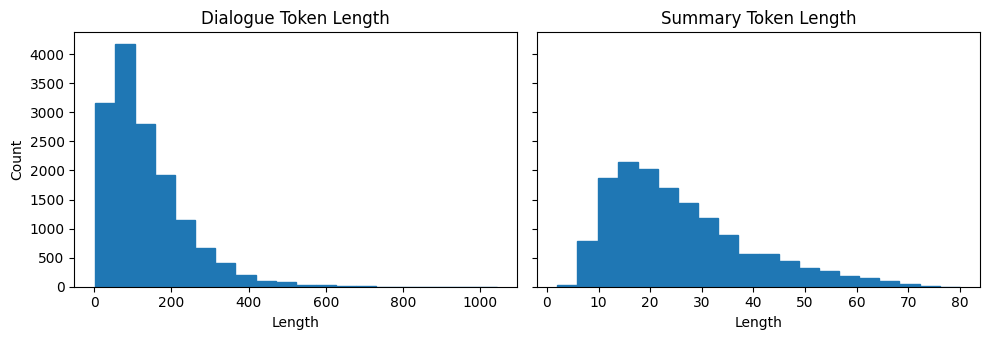

In [13]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['dialogue']]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['summary']]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color='C0', edgecolor='C0')
axes[0].set_title('Dialogue Token Length')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Count')
axes[1].hist(s_len, bins=20, color='C0', edgecolor='C0')
axes[1].set_title('Summary Token Length')
axes[1].set_xlabel('Length')
plt.tight_layout()
plt.show()

```
대부분 대화는 100~200개 토큰으로 구성되며 CNN/DailyMail 기사보다 훨씬 더 짧음

마찬가지로 요약도 20~30개 토큰(평균 트윗 길이)으로 구성되며 훨씬 더 짧음

이런 점을 유념하면서 Trainer 를 위한 데이터 콜레이터를 만들겠음

먼저 데이터셋을 토큰화하자.

대화와 요약의 최대 길이를 각각 1024와 128로 설정하겠음
```

In [13]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'], max_length=1024,
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodigns = tokenizer(example_batch['summary'], max_length=128,
                                     truncation=True)
        
    return {'input_ids': input_encodings['input_ids'],
            'attention_mask': input_encodings['attention_mask'],
            'labels': target_encodigns['input_ids']}

In [14]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ['input_ids', 'labels', 'attention_mask']
dataset_samsum_pt.set_format(type='torch', columns=columns)

Parameter 'function'=<function convert_examples_to_features at 0x7f55bce1f670> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

```
토큰화 단계에 새롭게 적용한 것은 tokenizer.as_target_tokenizer() 임

일부 모델은 디코더 입력에 특수 토큰이 필요함

따라서 인코더와 디코더 입력의 토큰화를 구별하는 것이 중요함

(컨텍스트 매니저(Context Manager)라 부르는) with 문을 사용하면 토크나이저가 디코더를 위한 토큰화임을 인지하고 그에 따라 시퀀스를 처리할 수 있음

이제 데이터 콜레이터를 만듭니다.

이 함수는 배치를 모델에 주입하기 전에 Trainer 에 의해 호출됨

대부분의 경우 단순히 배치에 있는 모든 텐서를 가져오 쌓는 기본 콜레이터를 사용함

요약 작업에서는 입력을 쌓을 뿐만 아니라 디코더 쪽의 타깃도 준비함

PEGASUS 는 인코더-디코더 트랜스포머이고, 따라서 고전적인 seq2seq 구조를 취함

seq2seq 구조에서는 디코더에 '티처 포싱(Teacher Forcing)'을 적용하는 것이 일반적임

이 전략에서는 (GPT-2 등의 디코더 전용 모델처럼) 디코더가 인코더 출력 외에 한 토큰이 이동된 레이블로 구성된 입력 토큰을 받음

따라서 아래 표처럼 다음 토큰을 위한 예측을 만들 때 디코더는 한 토큰이 이동된 정답을 입력으로 받음
```

In [16]:
# 티처 포싱(Teacher Forcing)
# 텍스트 생성을 위한 디코더 입력과 레이블의 정렬
text = ['PAD', 'Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text) - 1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


```
한 스텝 이동했으므로 디코더는 이전 스템의 정답 레이블만 보며 현재와 미래의 레이블을 보지 못함

디코더는 현재와 미래의 모든 입력을 마스킹하는 마스크드 셀프 어텐션을 갖기 때문에 이동시키는 것으로 충분함

따라서 배치를 준비할 때 레이블을 한 스텝 오른쪽으로 이동시켜 디코더 입력을 만듦

그런 다음 레이블에 있는 패딩 토큰을 -100 으로 설정해 손실 함수가 무시하도록 만듦

그러나 DataColloatorForSeq2Seq 에서 이런 작업을 모두 처리하므로 실제로 이를 수동으로 할 필요가 없음
```

In [15]:
from transformers import DataCollatorForSeq2Seq

In [16]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

```
이제 이전처럼 훈련을 위해 TrainingArguments 를 설정하자
```

In [17]:
from transformers import TrainingArguments, Trainer

In [20]:
training_args = TrainingArguments(
    output_dir='pegasus-samsum', 
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    push_to_hub=True,
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16,
)

```
이전과 달리 새 매개변수 gradient_accumulation_steps 가 추가되었음

모델이 매우 크니 배치 크기를 1로 지정하는데, 배치 크기가 너무 작으면 수렴하지 않음

이 문제를 해결하기 위해 그레디언트 누적(Gradient Accumulation)이라는 멋진 기술을 사용함

이름 그대로 큰 배치의 그레이덩ㄴ트를 한 번에 계산하는 대신 작은 배치를 만들고 그레디언트를 누적하는 방식임

그레디언트가 충분히 누적되면 최적화 단계를 수행함

당연히 이는 한 번에 실행하는 것보다 조금 더 느림

하지만 GPU 메모리가 많이 절약됨

훈련이 끝난 후 모델을 허브에 저장하기 위해 허깅페이스에 로그인함
```

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

```
이제 Trainer 를 초기화하기 위해 필요한 모델, 토크나이저, 훈련 매개변수, 데이터 콜레이터, 훈련 세트, 평가 세트가 모두 준비됐음
```

In [19]:
trainer = Trainer(model=model, 
                  args=training_args,
                  tokenizer=tokenizer,
                  data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt['train'],
                  eval_dataset=dataset_samsum_pt['validation'],
                 )

/data/heerak/workspace/nlp-with-transformers/pegasus-samsum is already a clone of https://huggingface.co/Heerak/pegasus-samsum. Make sure you pull the latest changes with `repo.git_pull()`.


```
훈련할 준비가 끝났음

훈련을 마친 후 테스트 세트로 평가 함수를 실행해 모델의 성능을 확인함
```

In [20]:
trainer.train()
score = evaluate_summaries_pegasus(dataset_samsum['test'],
                                   rouge_metric,
                                   trainer.model,
                                   tokenizer,
                                   batch_size=2,
                                   column_text='dialogue',
                                   column_summary='summary')

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=['pegasus'])

The following columns in the training set  don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: id, summary, dialogue.
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: raki-1203. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


RuntimeError: CUDA out of memory. Tried to allocate 376.00 MiB (GPU 0; 10.76 GiB total capacity; 8.95 GiB already allocated; 189.25 MiB free; 9.03 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

```
미세 튜닝하지 않은 모델에 비해 ROUGE 점수가 상당히 향상됐음

이전 모델도 요약에 대해 훈련됐지만 새로운 데이터셋에 잘 적응하지 못했음

이 모델을 허브에 저장하자
```

In [1]:
trainer.push_to_hub('Training complete!')

NameError: name 'trainer' is not defined

>TIP<br>훈련 루프의 일부로 생성된 텍스트를 평가할 수 있음<br>Seq2SeqTrainingArguments 란 이름의 TrainingArguments 의 확장을 사용하고 predict_with_generate=True 를 지정합니다.<br>이를 Seq2SeqTrainer 란 이름의 전용 Trainer 에 전달합니다.<br>그러면 평가를 위해 모델의 정방향 패스가 아니라 generate() 함수를 사용해 예측을 만듭니다.

### 6.6.3 대화 요약 생성하기

```
손실과 ROUGE 점수를 보면 CNN/DailyMail 에서만 훈련한 원래 모델보다 크게 향상된 것 같음

테스트 세트에 있는 샘플로 어떤 요약이 만들어지는지 확인해보자.
```

In [2]:
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, 'max_length': 128}
sample_text = dataset_samsum['test'][0]['dialogue']
reference = dataset_samsum['test'][0]['summary']
# `transformersbook` 을 자신의 허브 사용자 이름으로 바꾸세요.
pipe = pipeline('summarization', model='transformersbook/pegasus-samsum')

print('대화:')
print(sample_text)
print('\n참조 요약:')
print(reference)
print('\n모델 요약:')
print(pipe(sample_text, **gen_kwargs)[0]['summary_texet'])

NameError: name 'dataset_samsum' is not defined

```
참조 번역과 훨씬 비슷해졌음

모델이 그냥 문장을 추출하지 않고 대화를 합성해서 요약을 만드는 법을 배운 것 같음

실제 대화 입력에서 이 모델이 얼마나 잘 동작할까?
```

In [3]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]['summary_text'])

NameError: name 'pipe' is not defined

```
임의로 작성한 대화에서 타당성 있는 요약을 생성했음

대화에서 그냥 하나의 문장을 뽑아 내지 않고 대화에 참여한 사람 모두가 책을 함께 쓰고 싶다는 내용을 잘 요약했음
```

## 6.7 결론

```
텍스트 요약은 감성 분석, 개체명 인식, 질문 답변과 같이 분류 작업으로 구성되는 작업에 비해 특수한 어려움이 몇 가지 있음

정확도 같은 전통적인 지표는 생성된 텍스트의 품질을 반영하지 못함

BLEU 와 ROUGE 지표가 생성된 텍스트를 더 잘 평가함

하지만 여전히 사람의 판단이 가장 좋은 척도임

요약 모델로 작업할 때는 주로 모델의 문맥 크기보다 긴 텍스트를 어떻게 요약할지에 의문이 생김

안타깝게도 이 문제를 해결할 수 있는 단일 전략은 없음

아직까지도 활발하게 연구되고 있는 미결의 문제임

OpenAI 의 최근 연구는 긴 문서에 반복적으로 모델을 적용하고 사람의 피드백을 반복 루프에 추가해 요약 작업의 스케일을 확장했음

다음 장에서 텍스트 기반의 질문에 답을 제공하는 질문 답변에 대해 알아보겠음

요약과 달리, 이 작업에는 길이가 길거나 대량의 문서를 다룰 좋은 전략이 있음

질문 답변 작업을 수천 개의 문서로 확장하는 방법을 알아보겠음
```